In [0]:
!pip install -q keras

In [0]:
!pip install -q pydot

In [0]:
!pip install graphviz 
!apt-get install graphviz

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  fontconfig libann0 libcairo2 libcdt5 libcgraph6 libdatrie1 libgd3
  libgts-0.7-5 libgts-bin libgvc6 libgvpr2 libjbig0 liblab-gamut1 libltdl7
  libpango-1.0-0 libpangocairo-1.0-0 libpangoft2-1.0-0 libpathplan4
  libpixman-1-0 libthai-data libthai0 libtiff5 libwebp6 libxaw7 libxcb-render0
  libxcb-shm0 libxmu6 libxpm4 libxt6
Suggested packages:
  gsfonts graphviz-doc libgd-tools
The following NEW packages will be installed:
  fontconfig graphviz libann0 libcairo2 libcdt5 libcgraph6 libdatrie1 libgd3
  libgts-0.7-5 libgts-bin libgvc6 libgvpr2 libjbig0 liblab-gamut1 libltdl7
  libpango-1.0-0 libpangocairo-1.0-0 libpangoft2-1.0-0 libpathplan4
  libpixman-1-0 libthai-data libthai0 libtiff5 libwebp6 libxaw7 libxcb-render0
  libxcb-shm0 libxmu6 libxpm4 libxt6
0 upgraded, 30 newly installed, 0 to remove and 5 not upgraded.
Need to get 4,154 kB of

In [0]:
from keras.models import Model
from keras.layers import Input
from keras.layers import LSTM
from keras.layers import Dense
from keras.utils.vis_utils import plot_model

Using TensorFlow backend.


In [0]:
# configure
num_encoder_tokens = 71
num_decoder_tokens = 93
latent_dim = 256

In [0]:
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

In [0]:
encoder_states = [state_h, state_c]
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))

In [0]:
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [0]:
# Define the model that will turn
# encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [0]:
# plot the model
plot_model(model, to_file='model.png', show_shapes=True)

In [0]:
# define encoder inference model
encoder_model = Model(encoder_inputs, encoder_states)

In [0]:
# define decoder inference model
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

In [0]:
# summarize model
plot_model(encoder_model, to_file='encoder_model.png', show_shapes=True)
plot_model(decoder_model, to_file='decoder_model.png', show_shapes=True)

In [0]:
!ls

decoder_model.png  encoder_model.png  model.png  sample_data


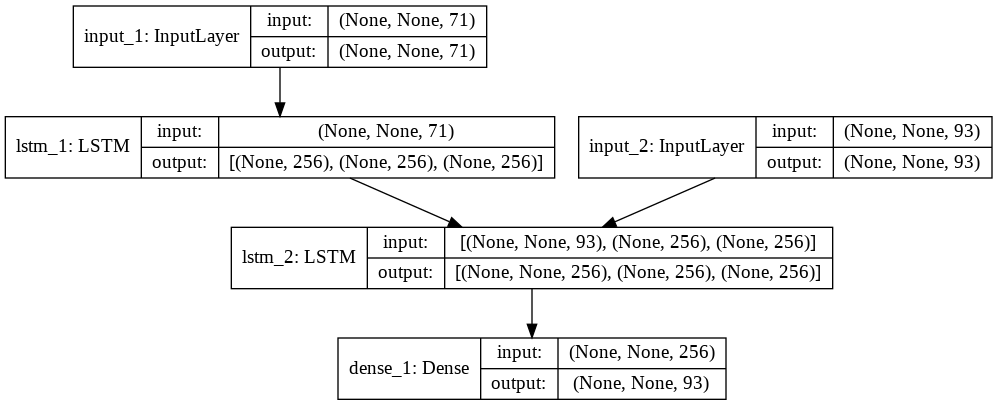

In [0]:
from IPython.display import Image
Image('model.png')

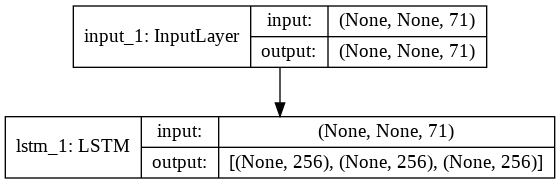

In [0]:
Image('encoder_model.png')

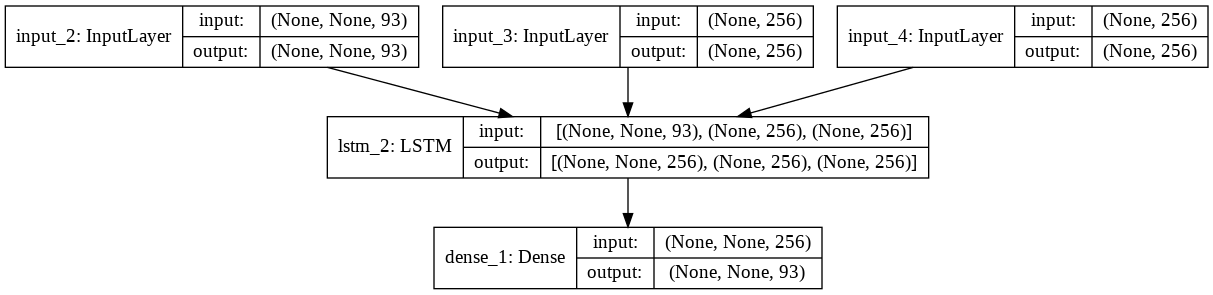

In [0]:
Image('decoder_model.png')

In [0]:
from random import randint
from numpy import array
from numpy import argmax
from numpy import array_equal
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Input
from keras.layers import LSTM
from keras.layers import Dense

In [0]:
! pip install SciPy

1. German to English Translation Dataset
2. Preparing the Text Data
3. Train Neural Translation Model
4. Evaluate Neural Translation Model

In [0]:
! wget http://www.manythings.org/anki/deu-eng.zip
! unzip deu-eng.zip

--2018-11-20 23:14:43--  http://www.manythings.org/anki/deu-eng.zip
Resolving www.manythings.org (www.manythings.org)... 104.24.109.196, 104.24.108.196, 2606:4700:30::6818:6dc4, ...
Connecting to www.manythings.org (www.manythings.org)|104.24.109.196|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4162728 (4.0M) [application/zip]
Saving to: ‘deu-eng.zip’

deu-eng.zip         100%[===================>]   3.97M  1.56MB/s    in 2.5s    

2018-11-20 23:14:45 (1.56 MB/s) - ‘deu-eng.zip’ saved [4162728/4162728]

Archive:  deu-eng.zip
  inflating: deu.txt                 
  inflating: _about.txt              


In [0]:
cat -n deu.txt

     1	Hi.	Hallo!
     2	Hi.	Grüß Gott!
     3	Run!	Lauf!
     4	Wow!	Potzdonner!
     5	Wow!	Donnerwetter!
     6	Fire!	Feuer!
     7	Help!	Hilfe!
     8	Help!	Zu Hülf!
     9	Stop!	Stopp!
    10	Wait!	Warte!
    11	Go on.	Mach weiter.
    12	Hello!	Hallo!
    13	I ran.	Ich rannte.
    14	I see.	Ich verstehe.
    15	I see.	Aha.
    16	I try.	Ich probiere es.
    17	I won!	Ich hab gewonnen!
    18	I won!	Ich habe gewonnen!
    19	Smile.	Lächeln!
    20	Cheers!	Zum Wohl!
    21	Freeze!	Keine Bewegung!
    22	Freeze!	Stehenbleiben!
    23	Got it?	Kapiert?
    24	Got it?	Verstanden?
    25	Got it?	Einverstanden?
    26	He ran.	Er rannte.
    27	He ran.	Er lief.
    28	Hop in.	Mach mit!
    29	Hug me.	Drück mich!
    30	Hug me.	Nimm mich in den Arm!
    31	Hug me.	Umarme mich!
    32	I fell.	Ich fiel.
    33	I fell.	Ich fiel hin.
    34	I fell.	Ich stürzte.
    35	I fell.	Ich bin hingefallen.
    36	I fell.	Ich bin gestürzt.
    37	I know.	Ich weiß.
    38	I lied.	Ich habe gelogen.
    39	

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [0]:
# clean text
def load_doc(filename):
	# open the file as read only
	file = open(filename, mode='rt', encoding='utf-8')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

In [0]:
# split a loaded document into sentences
def to_pairs(doc):
	lines = doc.strip().split('\n')
	pairs = [line.split('\t') for line in  lines]
	return pairs

In [0]:
# clean a list of lines
def clean_pairs(lines):
	cleaned = list()
	# prepare regex for char filtering
	re_print = re.compile('[^%s]' % re.escape(string.printable))
	# prepare translation table for removing punctuation
	table = str.maketrans('', '', string.punctuation)
	for pair in lines:
		clean_pair = list()
		for line in pair:
			# normalize unicode characters
			line = normalize('NFD', line).encode('ascii', 'ignore')
			line = line.decode('UTF-8')
			# tokenize on white space
			line = line.split()
			# convert to lowercase
			line = [word.lower() for word in line]
			# remove punctuation from each token
			line = [word.translate(table) for word in line]
			# remove non-printable chars form each token
			line = [re_print.sub('', w) for w in line]
			# remove tokens with numbers in them
			line = [word for word in line if word.isalpha()]
			# store as string
			clean_pair.append(' '.join(line))
		cleaned.append(clean_pair)
	return array(cleaned)

In [0]:
import string
import re
from pickle import dump
from unicodedata import normalize
from numpy import array

In [0]:
# save a list of clean sentences to file
def save_clean_data(sentences, filename):
	dump(sentences, open(filename, 'wb'))
	print('Saved: %s' % filename)

  # load dataset
filename = 'deu.txt'
doc = load_doc(filename)
# split into english-german pairs
pairs = to_pairs(doc)
# clean sentences
clean_pairs = clean_pairs(pairs)
# save clean pairs to file
save_clean_data(clean_pairs, 'english-german.pkl')
# spot check
for i in range(100):
	print('[%s] => [%s]' % (clean_pairs[i,0], clean_pairs[i,1]))


Saved: english-german.pkl
[hi] => [hallo]
[hi] => [gru gott]
[run] => [lauf]
[wow] => [potzdonner]
[wow] => [donnerwetter]
[fire] => [feuer]
[help] => [hilfe]
[help] => [zu hulf]
[stop] => [stopp]
[wait] => [warte]
[go on] => [mach weiter]
[hello] => [hallo]
[i ran] => [ich rannte]
[i see] => [ich verstehe]
[i see] => [aha]
[i try] => [ich probiere es]
[i won] => [ich hab gewonnen]
[i won] => [ich habe gewonnen]
[smile] => [lacheln]
[cheers] => [zum wohl]
[freeze] => [keine bewegung]
[freeze] => [stehenbleiben]
[got it] => [kapiert]
[got it] => [verstanden]
[got it] => [einverstanden]
[he ran] => [er rannte]
[he ran] => [er lief]
[hop in] => [mach mit]
[hug me] => [druck mich]
[hug me] => [nimm mich in den arm]
[hug me] => [umarme mich]
[i fell] => [ich fiel]
[i fell] => [ich fiel hin]
[i fell] => [ich sturzte]
[i fell] => [ich bin hingefallen]
[i fell] => [ich bin gesturzt]
[i know] => [ich wei]
[i lied] => [ich habe gelogen]
[i lost] => [ich habe verloren]
[i paid] => [ich habe bezah

# Split text



In [0]:
from numpy import array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Embedding
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.callbacks import ModelCheckpoint

from pickle import load
from pickle import dump
from numpy.random import rand
from numpy.random import shuffle

from numpy import argmax
from keras.models import load_model
from nltk.translate.bleu_score import corpus_bleu

saving clearn data in pkl files

In [0]:
# load a clean dataset
def load_clean_sentences(filename):
	return load(open(filename, 'rb'))

# save a list of clean sentences to file
def save_clean_data(sentences, filename):
	dump(sentences, open(filename, 'wb'))
	print('Saved: %s' % filename)

# load dataset
raw_dataset = load_clean_sentences('english-german.pkl')

# reduce dataset size
n_sentences = 10000
dataset = raw_dataset[:n_sentences, :]
# random shuffle
shuffle(dataset)
# split into train/test
train, test = dataset[:9000], dataset[9000:]
# save
save_clean_data(dataset, 'english-german-both.pkl')
save_clean_data(train, 'english-german-train.pkl')
save_clean_data(test, 'english-german-test.pkl')

Saved: english-german-both.pkl
Saved: english-german-train.pkl
Saved: english-german-test.pkl


In [0]:

# load a clean dataset
def load_clean_sentences(filename):
	return load(open(filename, 'rb'))

# fit a tokenizer
def create_tokenizer(lines):
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer

# max sentence length
def max_length(lines):
	return max(len(line.split()) for line in lines)

# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
	# integer encode sequences
	X = tokenizer.texts_to_sequences(lines)
	# pad sequences with 0 values
	X = pad_sequences(X, maxlen=length, padding='post')
	return X

# one hot encode target sequence
def encode_output(sequences, vocab_size):
	ylist = list()
	for sequence in sequences:
		encoded = to_categorical(sequence, num_classes=vocab_size)
		ylist.append(encoded)
	y = array(ylist)
	y = y.reshape(sequences.shape[0], sequences.shape[1], vocab_size)
	return y


# define NMT model
def define_model(src_vocab, tar_vocab, src_timesteps, tar_timesteps, n_units):
	model = Sequential()
	model.add(Embedding(src_vocab, n_units, input_length=src_timesteps, mask_zero=True))
	model.add(LSTM(n_units))
	model.add(RepeatVector(tar_timesteps))
	model.add(LSTM(n_units, return_sequences=True))
	model.add(TimeDistributed(Dense(tar_vocab, activation='softmax')))
	return model

In [0]:
dataset = load_clean_sentences('english-german-both.pkl')
train = load_clean_sentences('english-german-train.pkl')
test = load_clean_sentences('english-german-test.pkl')

In [0]:
# prepare english tokenizer
eng_tokenizer = create_tokenizer(dataset[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_length = max_length(dataset[:, 0])
print('English Vocabulary Size: %d' % eng_vocab_size)
print('English Max Length: %d' % (eng_length))
# prepare german tokenizer
ger_tokenizer = create_tokenizer(dataset[:, 1])
ger_vocab_size = len(ger_tokenizer.word_index) + 1
ger_length = max_length(dataset[:, 1])
print('German Vocabulary Size: %d' % ger_vocab_size)
print('German Max Length: %d' % (ger_length))

English Vocabulary Size: 2309
English Max Length: 5
German Vocabulary Size: 3657
German Max Length: 10


In [0]:
# prepare training data
trainX = encode_sequences(ger_tokenizer, ger_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])
trainY = encode_output(trainY, eng_vocab_size)
# prepare validation data
testX = encode_sequences(ger_tokenizer, ger_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])
testY = encode_output(testY, eng_vocab_size)

In [0]:
# define model
model = define_model(ger_vocab_size, eng_vocab_size, ger_length, eng_length, 256)
model.compile(optimizer='adam', loss='categorical_crossentropy')
# summarize defined model
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 10, 256)           936192    
_________________________________________________________________
lstm_3 (LSTM)                (None, 256)               525312    
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 5, 256)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 5, 256)            525312    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 5, 2309)           593413    
Total params: 2,580,229
Trainable params: 2,580,229
Non-trainable params: 0
_________________________________________________________________
None


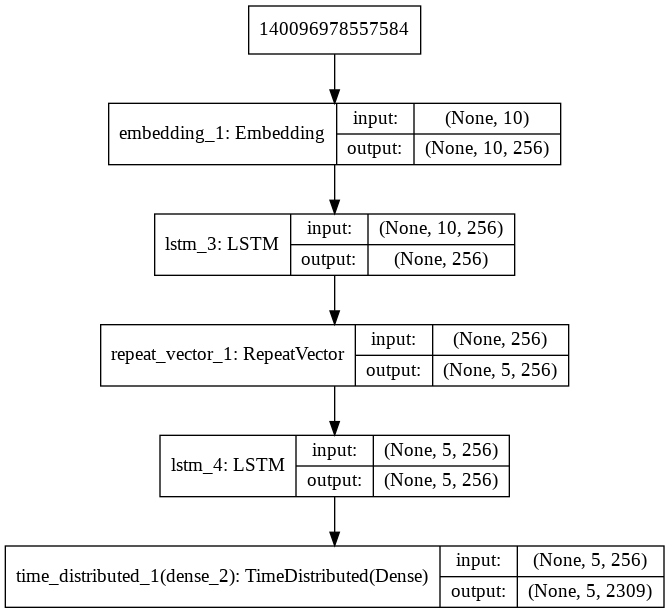

In [0]:
plot_model(model, to_file='model_MT.png', show_shapes=True)
from IPython.display import Image
Image('model_MT.png')

In [0]:
# fit model
filename = 'model_MT.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
model.fit(trainX, trainY, epochs=30, batch_size=64, validation_data=(testX, testY), callbacks=[checkpoint], verbose=2)

Train on 9000 samples, validate on 1000 samples
Epoch 1/30
 - 12s - loss: 4.3320 - val_loss: 3.5921

Epoch 00001: val_loss improved from inf to 3.59211, saving model to model_MT.h5
Epoch 2/30
 - 9s - loss: 3.4058 - val_loss: 3.4327

Epoch 00002: val_loss improved from 3.59211 to 3.43265, saving model to model_MT.h5
Epoch 3/30
 - 9s - loss: 3.2597 - val_loss: 3.3568

Epoch 00003: val_loss improved from 3.43265 to 3.35682, saving model to model_MT.h5
Epoch 4/30
 - 9s - loss: 3.1345 - val_loss: 3.2511

Epoch 00004: val_loss improved from 3.35682 to 3.25109, saving model to model_MT.h5
Epoch 5/30
 - 9s - loss: 2.9963 - val_loss: 3.1634

Epoch 00005: val_loss improved from 3.25109 to 3.16345, saving model to model_MT.h5
Epoch 6/30
 - 9s - loss: 2.8429 - val_loss: 3.0206

Epoch 00006: val_loss improved from 3.16345 to 3.02064, saving model to model_MT.h5
Epoch 7/30
 - 9s - loss: 2.6641 - val_loss: 2.8964

Epoch 00007: val_loss improved from 3.02064 to 2.89645, saving model to model_MT.h5
Epo

Evaluate NN MT model

In [0]:
# map an integer to a word
def word_for_id(integer, tokenizer):
	for word, index in tokenizer.word_index.items():
		if index == integer:
			return word
	return None

# generate target given source sequence
def predict_sequence(model, tokenizer, source):
	prediction = model.predict(source, verbose=0)[0]
	integers = [argmax(vector) for vector in prediction]
	target = list()
	for i in integers:
		word = word_for_id(i, tokenizer)
		if word is None:
			break
		target.append(word)
	return ' '.join(target)



# evaluate the skill of the model
def evaluate_model(model, tokenizer, sources, raw_dataset):
	actual, predicted = list(), list()
	for i, source in enumerate(sources):
		# translate encoded source text
		source = source.reshape((1, source.shape[0]))
		translation = predict_sequence(model, eng_tokenizer, source)
		raw_target, raw_src = raw_dataset[i]
		if i < 10:
			print('src=[%s], target=[%s], predicted=[%s]' % (raw_src, raw_target, translation))
		actual.append(raw_target.split())
		predicted.append(translation.split())
	# calculate BLEU score
	print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
	print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
	print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
	print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))



In [0]:
from keras.models import load_model
# load model
model = load_model('model_MT.h5')

# test on some training sequences
print('train')
evaluate_model(model, eng_tokenizer, trainX, train)
# test on some test sequences
print('test')
evaluate_model(model, eng_tokenizer, testX, test)

train
src=[ist das normal], target=[is that normal], predicted=[is that normal]
src=[bitte nehmt euch eins], target=[please take one], predicted=[please take one]
src=[sehen sie tom zu], target=[watch tom], predicted=[go tom again]
src=[ich bin ausgeflippt], target=[i freaked out], predicted=[i freaked out]
src=[sie sind unglaublich], target=[youre amazing], predicted=[youre amazing]
src=[jetzt bist du in sicherheit], target=[now youre safe], predicted=[now youre safe]
src=[ich gehe gerne joggen], target=[i like running], predicted=[i like to]
src=[nehmt meinen wagen], target=[take my car], predicted=[take my car]
src=[warum ist es dunkel], target=[why is it dark], predicted=[why is it dark]
src=[sing weiter], target=[keep singing], predicted=[keep singing]


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


BLEU-1: 0.078964
BLEU-2: 0.271708
BLEU-3: 0.445421
BLEU-4: 0.504009
test
src=[tom war unordentlich], target=[tom was untidy], predicted=[tom was sneaky]
src=[ich rede viel], target=[i talk a lot], predicted=[i often a lot]
src=[beruhige dich], target=[take it easy], predicted=[calm down]
src=[vertrauen sie tom], target=[trust tom], predicted=[do you know tom]
src=[ich will einen anwalt], target=[i want a lawyer], predicted=[i want a one]
src=[schreib mir], target=[write me], predicted=[write to me]
src=[hey geh nicht], target=[hey dont go], predicted=[dont be quiet]
src=[tom kann nicht kochen], target=[tom cant cook], predicted=[tom cant well]
src=[die sache ist ernst], target=[its serious], predicted=[it hurts sad]
src=[du siehst glucklich aus], target=[you look happy], predicted=[you look busy]
BLEU-1: 0.080092
BLEU-2: 0.274637
BLEU-3: 0.449600
BLEU-4: 0.508561
